# DTSA 5511 Final Project

## Step 1: Project Overview

Asset evaluation is very important to stakeholders in the financial industry. Both individual and institutional investors rely on accurate predictions to make informed decisions regarding buying and selling stocks. Traders and fund managers require timely and accurate information to optimize their investment strategies. Accurate price predictions can help mitigate risks, identify investment opportunities, and potentially maximize returns.

The problem with the financial markets is the inherent uncertainty and volatility associated with the price movements in the underlying assets. Predicting these movements is a difficult task due to the variety of factors that influence stock prices, including market trends, economic indicators, company financials, and investor sentiment. The challenge lies in accurately capturing and analyzing these factors to generate reliable predictions.

The purpose of this project is to develop a predictive model for stock price movements using historical market data. The goal of my model is to uncover patterns and insights that can be used as signals to assist investors and traders in making better informed decisions regarding their investment strategies. My approach involves leveraging deep learning and algorithms to accurately forecast short-term trends in the equities markets.

In [84]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

import yfinance as yf
import pandas_ta as pta

import warnings
warnings.filterwarnings("ignore")

## Step 2: Collect Data

The data used in this project contains historical market data for Apple (AAPL) from 1990 to 2023. I used Yahoo Finance's publically available API to scrape the data and store it in a Pandas dataframe. The table below holds daily records containing the following columns (all quantitative):

Date: trade date

Open: AAPL price at time of market open

High: highest price of AAPL during trading day

Low: lowest price of AAPL during trading day

Close: AAPL price at time of market close

Adj Close: AAPL closing price after dividends / splits

Volume: # of shares traded during trading day

In [60]:
df = yf.download(tickers='AAPL', start='1990-01-01', end='2023-01-01', interval='1d') 
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263414,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.265181,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.266066,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266950,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268718,101572800
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.127075,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.307220,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.339409,85438400


## Step 3: Exploratory Data Analysis (EDA)

### Data Cleaning

I began the EDA stage by inspecting the raw data. It appears that the dataframe contains 8,315 rows with the 6 columns mentioned above. Furthermore, there aren't any null values which simplifies the data cleaning process.

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8315 entries, 1990-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8315 non-null   float64
 1   High       8315 non-null   float64
 2   Low        8315 non-null   float64
 3   Close      8315 non-null   float64
 4   Adj Close  8315 non-null   float64
 5   Volume     8315 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 454.7 KB


In the next cell, I removed the "Close" column since "Adj Close" is a more representitive target variable. I then renamed "Adj Close" to "Close" to simplify the column names and reset the date index.

In [62]:
# drop close column
df = df.drop('Close', axis=1)

# rename column
df.rename(columns={'Adj Close': 'Close'}, inplace=True)

# reset index
df = df.reset_index()

df.head()

,Date,Open,High,Low,Close,Volume
0,1990-01-02,0.314732,0.334821,0.312500,0.263414,183198400
1,1990-01-03,0.339286,0.339286,0.334821,0.265181,207995200
2,1990-01-04,0.341518,0.345982,0.332589,0.266066,221513600
3,1990-01-05,0.337054,0.341518,0.330357,0.266950,123312000
4,1990-01-08,0.334821,0.339286,0.330357,0.268718,101572800


### Data Visualization

In the cell below, I visualized the distribution of each of the quantitative variables (disregard Date). As you can see from the plots, most of the features have a right skew which is to be expected since the values tend to concentrated at lower levels during the majority of the time period. However, I scaled these values before constructing my models to ensure that it wouldn't impact the analysis.

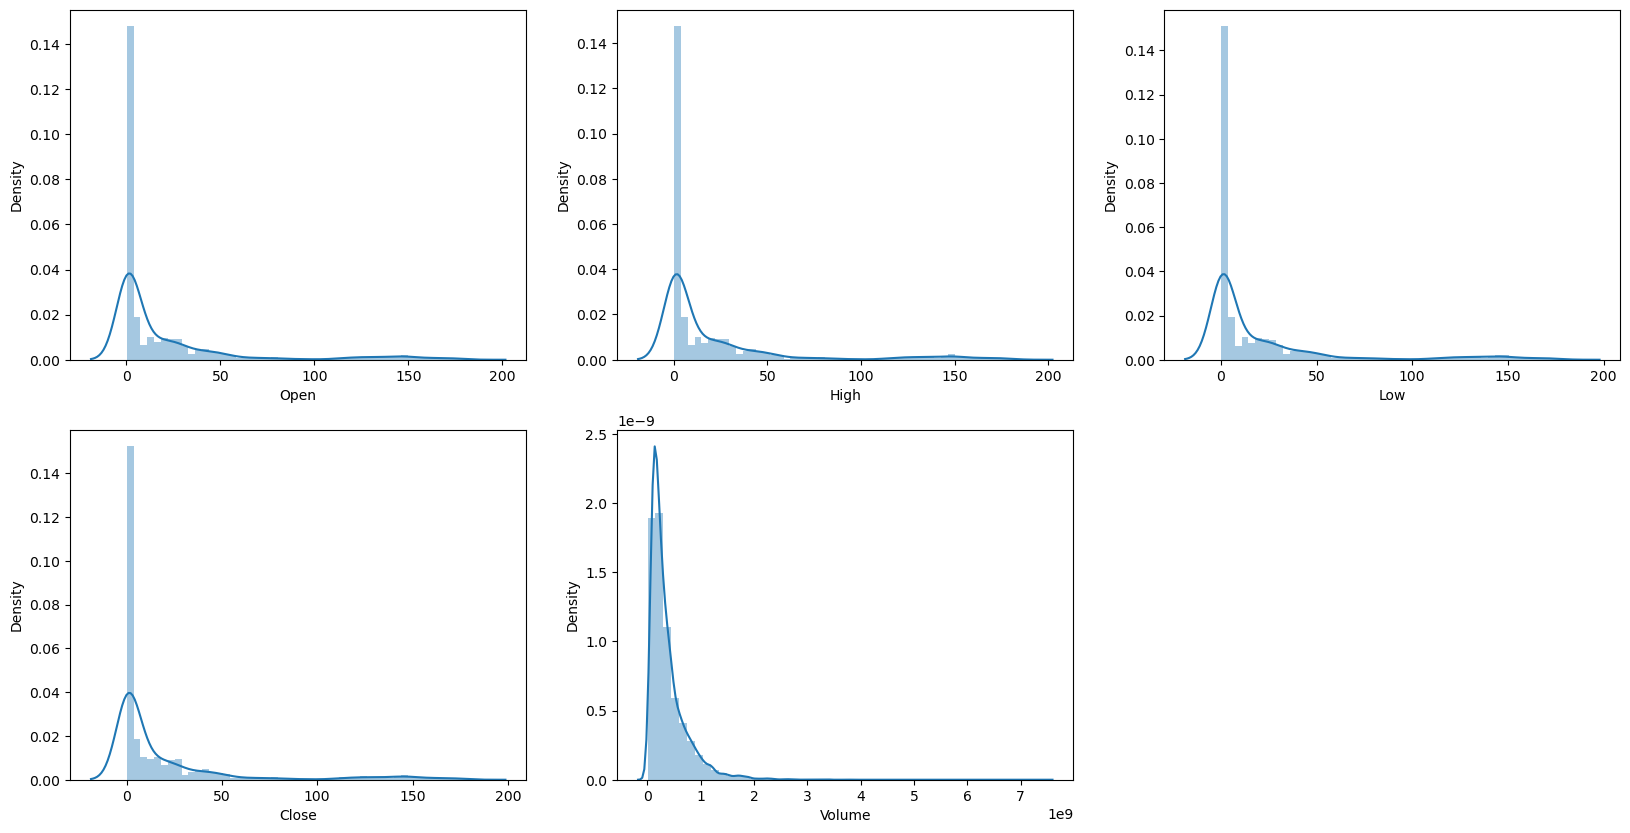

In [63]:
# select quantitative features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# create subplots
plt.subplots(figsize=(20,10))
 
# plot histograms
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.distplot(df[col])
plt.show()

Below, I created a correlation matrix with the remaining variables. The matrix suggests that the various price metrics (Open, High, Low, Close) are all highly correlated with each other (to be expected) though they have a low correlation with the shares traded (Volume). Due to the high multicollinearity, it doesn't make sense to include more than a single price feature in the models. Therefore, I needed to perform some feature engineering.

In [64]:
# analyze correlation between variables
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume
Open,1.000000,0.999935,0.999918,0.999551,-0.299587
High,0.999935,1.000000,0.999905,0.999667,-0.298945
Low,0.999918,0.999905,1.000000,0.999624,-0.300572
Close,0.999551,0.999667,0.999624,1.000000,-0.299909
Volume,-0.299587,-0.298945,-0.300572,-0.299909,1.000000


### Feature Engineering

In this next step, I used the Pandas Technical Analysis (TA) open source library to featurize the market data with technical indicators that can be used as potential features in my models. 

The 30-day moving average informs the model of the relative momentum associated with AAPL, whereas the Relative Strength Index (RSI) measures the speed and magnitude of AAPL's recent price changes relative to the rest of the industry. Both of these indicators contain crucial information that traders/investors use to evaluate the price of a security.

See below for implementation: 

In [65]:
# add 30 day rolling average
df['SMA_30'] = df['Close'].rolling(30).mean()

#add relative strength index (RSI)
df['RSI'] = pta.rsi(df['Close'], length = 14)

Below I created the target variable. Since the goal of our model is to predict the following day's closing price, I used the shift function to add the next day's closing price as an additional feature in the dataset.

In [66]:
# create target variable
df['Target'] = df['Close'].shift()

# remove null values
df = df.dropna()

In [68]:
df.head()

,Date,Open,High,Low,Close,Volume,SMA_30,RSI,Target
29,1990-02-12,0.305804,0.308036,0.301339,0.240431,74916800,0.245382,46.722479,0.242200
30,1990-02-13,0.303571,0.312500,0.301339,0.243967,102166400,0.244733,49.984879,0.240431
31,1990-02-14,0.308036,0.310268,0.301339,0.242200,96062400,0.243967,48.389779,0.243967
32,1990-02-15,0.301339,0.305804,0.299107,0.242200,97966400,0.243172,48.389779,0.242200
33,1990-02-16,0.305804,0.308036,0.301339,0.239432,127209600,0.242254,45.739624,0.242200


## Step 4: Model Analysis

In this stage of the project, I constructed multiple models to predict the next day's closing price. I chose to construct 2 different Long Short Term Memory (LSTM) models because they are specifically designed for sequential data modeling due to its capability to selectively remember or forget information over long time intervals. Therefore, they are well-suited for capturing long-term dependencies in stock price data.

### Data Preprocessing

Before constructing the models, there was some data preprocessing that needed to be implemented. I started by identifying the features and the target variable, and then used Sklearn's MinMaxScaler function to normalize the data. 

Once the data was standardized, I used sklearn's TimeSeriesSplit function to split the data into training and test sets. I used this function instead of the standard test/train split because of the sequential nature of time series data.

In [70]:
#Set Target Variable
output_var = pd.DataFrame(df['Target'])

#Selecting the Features
features = ['Close', 'Volume', 'SMA_30', 'RSI']

In [76]:
# scale data using MinMaxSclaer
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Close,Volume,SMA_30,RSI
29,0.000792,0.009775,0.000755,0.411977
30,0.000812,0.013447,0.000751,0.454817
31,0.000802,0.012625,0.000746,0.433871
32,0.000802,0.012881,0.000742,0.433871
33,0.000787,0.016823,0.000737,0.399071


In [112]:
# split data into training and test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

# process the data for LSTM model
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

### Model Construction

In the cells below, I constructed 2 different LSTM models. While both models have the same architecture, I chose different hyperparameters (learning rate) to assess the impact on the models' performance.

In [113]:
# set model 1 hyperparameters
optimizer_1 = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

# build LSTM 1
mod1 = Sequential()

mod1.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
mod1.add(Dense(1))
mod1.compile(loss='mean_squared_error', optimizer=optimizer_1)

In [114]:
# fit model 1
hist1 = mod1.fit(X_train, y_train, epochs=100, batch_size=8, shuffle=False)

Epoch 1/100
942/942 [==============================] - 1s 525us/step - loss: 11.2457
Epoch 2/100
942/942 [==============================] - 0s 507us/step - loss: 126.7807
Epoch 3/100
942/942 [==============================] - 0s 501us/step - loss: 57.0919
Epoch 4/100
942/942 [==============================] - 0s 497us/step - loss: 30.3831
Epoch 5/100
942/942 [==============================] - 0s 504us/step - loss: 13.7222
Epoch 6/100
942/942 [==============================] - 0s 497us/step - loss: 5.3519
Epoch 7/100
942/942 [==============================] - 0s 499us/step - loss: 1.9487
Epoch 8/100
942/942 [==============================] - 0s 503us/step - loss: 0.7717
Epoch 9/100
942/942 [==============================] - 0s 503us/step - loss: 0.3918
Epoch 10/100
942/942 [==============================] - 0s 506us/step - loss: 0.2599
Epoch 11/100
942/942 [==============================] - 0s 509us/step - loss: 0.2066
Epoch 12/100
942/942 [==============================] - 0s 499us/ste

942/942 [==============================] - 0s 490us/step - loss: 0.0936
Epoch 98/100
942/942 [==============================] - 0s 491us/step - loss: 0.0935
Epoch 99/100
942/942 [==============================] - 0s 490us/step - loss: 0.0934
Epoch 100/100
942/942 [==============================] - 0s 492us/step - loss: 0.0933


In [115]:
# model 1 predictions
y_pred_1 = mod1.predict(X_test)

24/24 [==============================] - 0s 396us/step


In [116]:
# set model 2 hyperparameters
optimizer_2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

# build LSTM 1
mod2 = Sequential()

mod2.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
mod2.add(Dense(1))
mod2.compile(loss='mean_squared_error', optimizer=optimizer_2)

In [117]:
# fit model 2
hist2 = mod2.fit(X_train, y_train, epochs=100, batch_size=8, shuffle=False)

Epoch 1/100
942/942 [==============================] - 1s 510us/step - loss: 2.0086
Epoch 2/100
942/942 [==============================] - 0s 492us/step - loss: 14.3796
Epoch 3/100
942/942 [==============================] - 0s 492us/step - loss: 10.7918
Epoch 4/100
942/942 [==============================] - 0s 492us/step - loss: 2.1892
Epoch 5/100
942/942 [==============================] - 0s 490us/step - loss: 0.6155
Epoch 6/100
942/942 [==============================] - 0s 492us/step - loss: 0.2543
Epoch 7/100
942/942 [==============================] - 0s 490us/step - loss: 0.2204
Epoch 8/100
942/942 [==============================] - 0s 487us/step - loss: 0.2124
Epoch 9/100
942/942 [==============================] - 0s 485us/step - loss: 0.1992
Epoch 10/100
942/942 [==============================] - 0s 486us/step - loss: 0.1916
Epoch 11/100
942/942 [==============================] - 0s 487us/step - loss: 0.1883
Epoch 12/100
942/942 [==============================] - 0s 483us/step - 

942/942 [==============================] - 0s 491us/step - loss: 0.1308
Epoch 98/100
942/942 [==============================] - 0s 484us/step - loss: 0.1304
Epoch 99/100
942/942 [==============================] - 0s 492us/step - loss: 0.1299
Epoch 100/100
942/942 [==============================] - 0s 486us/step - loss: 0.1294


In [118]:
# model 2 predictions
y_pred_2 = mod2.predict(X_test)

24/24 [==============================] - 0s 387us/step


### Model Evaluation

To visualize the the models' performance, I plotted the predicted values against the true closing price on the following day. Though it's not obvious from the graph below, it appears that Model 2 outperforms Model 1. However, the in the following cell, I created a function that calculates the Root Mean Squared Error (RMSE) which measures the average distance between the predicted values and the true values. As you can see, Model 1 has a slighly lower RMSE which suggests that Model1 actually outperformed Model 2 on average.

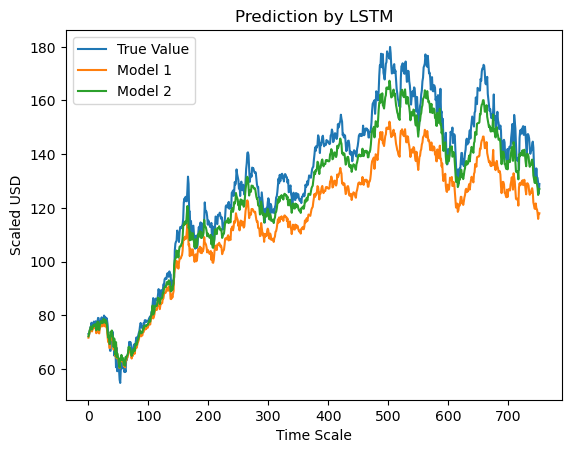

In [119]:
# model predictions vs true value
plt.plot(y_test, label='True Value')
plt.plot(y_pred_1, label='Model 1')
plt.plot(y_pred_2, label='Model 2')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [127]:
# function to calculate RMSE 
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

In [128]:
# calculate RMSE for both models
rmse1 = calculate_rmse(y_test, y_pred_1)
rmse2 = calculate_rmse(y_test, y_pred_2)

# print RMSE for both models
print('Model 1 RMSE: ', round(rmse1,2))
print('Model 2 RMSE: ', round(rmse2,2))

Model 1 RMSE:  40.83
Model 2 RMSE:  41.54


### Conclusions

The history of stock price prediction consists of two main approaches: fundamental analysis and technical analysis. Fundamental analysis focuses on evaluating a company's intrinsic value based on financial statements and fundamental factors. However, it has its limitations. Recent advancements in deep learning, particularly LSTM networks, CNNs, and RNNs, have shown promise in predicting stock price movements by capturing complex patterns in historical data. This project addresses these limitations by leveraging traditional technical indicators with the pattern recognition capabilities of LSTMs.

This analysis produced 2 LSTM models with similar architectural patterns and different hyperparameters. Both performed well in accurately predicting future stock prices, though the first model edged out Model 2 in terms of our evaluation metric: RMSE. While this is far from a complete analysis, I did discover a few key takeaways. Most notably, our model with the smaller learning rate (0.001) appeared to achieve better results with the current architecture. Its likely that the model with the larger learning rate (0.01) caused the model to learn the precise answer which resulted in overfitting.

Though there are a lot of positives to take away from this project, there are certainly areas which can be improved upon. For example, a more in-depth analysis could involve exploring deeper architectures, ensemble methods, and/or different hyperparameters to improve the performance. I chose LSTMs because they are specifically designed for sequential data modeling but it would also be worthwhile to compare LSTMs to other deep learning / machine learning models. Another interesting improvement involves using additional technical indicators from the Pandas TA library. There are hundreds of potential features that can be included as model parameters which might be able to capture the variability in the price movements. 

In conclusion, stock price prediction remains a relevant field with various stakeholders across the financial domain. Identifying patterns hidden within massive amounts of publicly available information has proved to be very lucrative, and the trend will likely continue due to new advancements in computation. This is a topic that I will continue to explore in the near future.

## Github Repository

Visit this link to see the full Github repository:
https://github.com/colincunningham-cu/dtsa_5511_final_project